In [8]:
import os
import tifffile
import numpy as np
from skimage import measure
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from phathom import io
from phathom import utils
from phathom import plotting
from phathom.phenotype import mesh
%matplotlib inline

In [9]:
working_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping/20181206_eF9_A34_1'

os.listdir(working_dir)

['20181206_eF9_A34_1.tif',
 'centers.tif',
 'morphology_major_axis.npy',
 'segmentation.pdf',
 'tbr1_bm3d',
 'tbr1_labels.npy',
 'foreground.tif',
 'Composite.tif',
 'syto16_4x_downsampled.raw',
 'Composite_small.gif',
 'nuclei_segmentation_downsampled_combined_syto_zoom.avi',
 'syto16.pdf',
 'single_cell_stdev.npy',
 'sox2_rich_smoothed.tif',
 'sox2_raw',
 'nuclei_seg_side-by-side.mp4',
 'sox2_bm3d',
 'sox2.zarr',
 'probability_map.pdf',
 'nuclei_segmentation-rgb-4x.avi',
 'foreground.zarr',
 'sox2_raw_4x_downsample',
 'nuclei_segmentation_downsampled_combined_syto_zoom2.avi',
 'faces.npy',
 '20181206_eF9_A34_1.lif',
 'morphology_volumes.npy',
 'values.npy',
 'syto16_4x_downsampled_vzseg_8bit.tif',
 'syto16_bm3d',
 'morphology_minor_axis.npy',
 'Composite.gif',
 'normals.png',
 'composite-images.avi',
 'pseg_compressed.tif',
 'segmentation.tif',
 'tbr1.zarr',
 'morphology_inertia_ratio.npy',
 'Composite_2x_downsampled.tif',
 'single_cell_mfi.npy',
 'tbr1_rich_raw.tif',
 'voxel_size.cs

In [10]:
centers = np.load(os.path.join(working_dir, 'centers.npy'))
centers.shape

(2421822, 3)

# Figure 2A - Nuclei detection + segmentation

In [11]:
syto = io.zarr.open(os.path.join(working_dir, 'syto16.zarr/1_1_1'))
syto.shape

(650, 2364, 2376)

In [12]:
start = np.array([125, 450, 275])
shape = np.array([2, 512, 512])

stop = start + shape
img = utils.extract_box(syto, start, stop)
img.shape

(2, 512, 512)

In [13]:
zpadding = 2
start_centers = start - np.array([zpadding, 0, 0])
stop_centers = stop + np.array([zpadding, 0, 0])
centers_box = utils.filter_points_in_box(centers, start_centers, stop_centers) - start
centers_box

array([[  0,  39, 164],
       [ -1,  18, 152],
       [ -2,  34, 149],
       ...,
       [  3, 506, 497],
       [  3, 470, 504],
       [  3, 510, 492]])

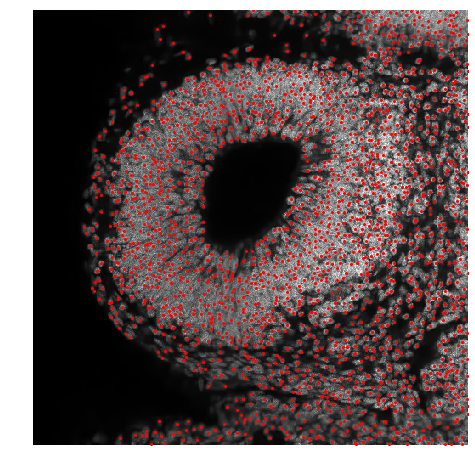

In [14]:
f = plt.figure(figsize=(8, 8))
plt.imshow(img.max(axis=0), cmap='gray', interpolation='none')
plt.plot(centers_box[:, 2], centers_box[:, 1], 'ro', markersize=2)
sns.despine()
plt.axis('off')
plt.show()
f.savefig(os.path.join(working_dir, 'detections.pdf'), bbox_inches='tight')

In [15]:
prob = io.zarr.open(os.path.join(working_dir, 'nuclei_probability.zarr'))
prob.shape

(650, 2364, 2376)

In [18]:
img_prob = utils.extract_box(prob, start, stop)
img_prob.shape

(2, 512, 512)

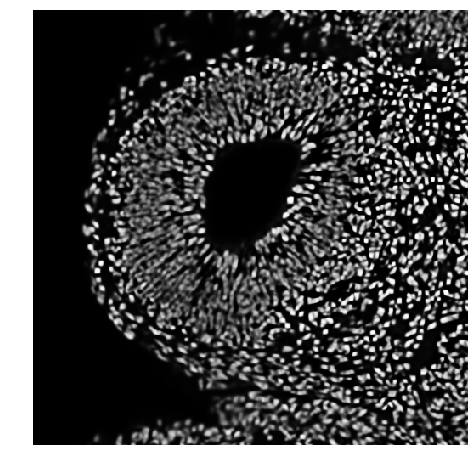

In [19]:
f = plt.figure(figsize=(8, 8))
plt.imshow(img_prob.max(axis=0), cmap='gray', interpolation='none')
sns.despine()
plt.axis('off')
plt.show()
f.savefig(os.path.join(working_dir, 'probability_map.pdf'), bbox_inches='tight')

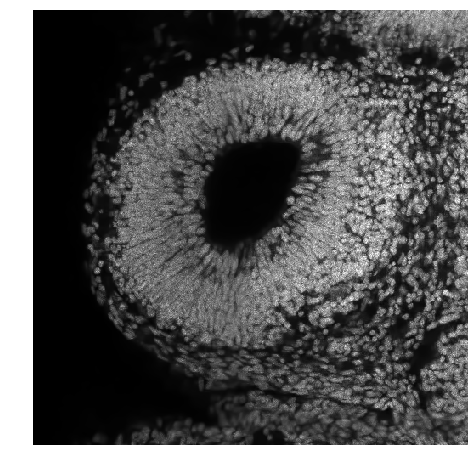

In [20]:
f = plt.figure(figsize=(8, 8))
plt.imshow(img.max(axis=0), cmap='gray', interpolation='none')
sns.despine()
plt.axis('off')
plt.show()
f.savefig(os.path.join(working_dir, 'syto16.pdf'), bbox_inches='tight')

In [12]:
seg = tifffile.imread(os.path.join(working_dir, 'pseg_compressed.tif'))
seg.shape

KeyboardInterrupt: 

In [21]:
img_seg = utils.extract_box(seg, start_centers, stop_centers)
img_seg.shape

NameError: name 'seg' is not defined

In [ ]:
np.random.seed(1256)
colors = np.random.rand(100000,3)**(2/3)
colors[0] = 0from tqdm import tqdm_notebook as tqdm
cmap = matplotlib.colors.ListedColormap(colors)

In [ ]:
data = img_seg[5]
data -= data.min()

f = plt.figure(figsize=(8, 8))
plt.imshow(data, cmap=cmap, interpolation='none')
sns.despine()
plt.axis('off')
plt.show()
f.savefig(os.path.join(working_dir, 'segmentation.pdf'), bbox_inches='tight')

In [54]:
tifffile.imsave(os.path.join(working_dir, 'segmentation.tif'), img_seg[5], compress=1)

# Figure 2B - Cell-type classification and histocytometry

In [22]:
tbr1 = io.zarr.open(os.path.join(working_dir, 'tbr1.zarr/1_1_1'))
tbr1.shape

(650, 2364, 2376)

In [23]:
sox2 = io.zarr.open(os.path.join(working_dir, 'sox2.zarr/1_1_1'))
sox2.shape

(650, 2364, 2376)

In [24]:
tbr1_labels = np.load(os.path.join(working_dir, 'tbr1_labels.npy'))
tbr1_labels.shape

(2421822,)

In [25]:
sox2_labels = np.load(os.path.join(working_dir, 'sox2_labels.npy'))
sox2_labels.shape

(2421822,)

In [26]:
# start = np.array([190, 1130, 540])
# shape = np.array([2, 350, 350])

start = np.array([120, 450, 550])
shape = np.array([2, 256, 256])

stop = start + shape
img_syto = utils.extract_box(syto, start, stop)
img_tbr1 = utils.extract_box(tbr1, start, stop)
img_sox2 = utils.extract_box(sox2, start, stop)
img_syto.shape

(2, 256, 256)

In [27]:
# n = 4096

# lut = np.zeros((n, 4))
# lut[:, 0] = np.linspace(0, 1, n)
# lut[:, -1] = 1
# lut[0, -1] = 1
# red = matplotlib.colors.ListedColormap(lut)

# lut = np.zeros((n, 4))
# lut[:, 1] = np.linspace(0, 1 , n)
# lut[:, -1] = np.linspace(0, 1 , n)
# green = matplotlib.colors.ListedColormap(lut)

# lut = np.zeros((4096, 4))
# lut[:, 2] = np.linspace(0, 1, n)
# lut[:, -1] = np.linspace(0, 1, n)
# lut[0, -1] = 1
# blue = matplotlib.colors.ListedColormap(lut)

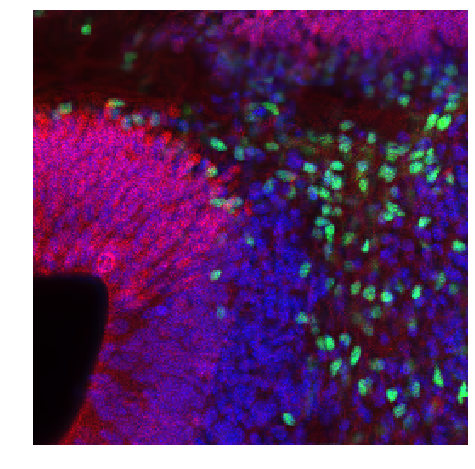

In [28]:
z = 0
rgb = np.zeros((*shape[1:], 3))
rgb[:, :, 0] = img_sox2[z]
rgb[:, :, 1] = img_tbr1[z]
rgb[:, :, 2] = img_syto[z]

rgb = rgb / rgb.max(axis=(0, 1))

f = plt.figure(figsize=(8, 8))
plt.imshow(rgb, interpolation='none')
sns.despine()
plt.axis('off')
plt.show()

In [29]:
zpadding = 2
start_centers = start - np.array([zpadding, 0, 0])
stop_centers = stop + np.array([zpadding, 0, 0])
centers_box_global, idx = utils.filter_points_in_box(centers, start_centers, stop_centers, return_idx=True)
centers_box = centers_box_global - start
centers_box, idx

(array([[  3,  60,   0],
        [  2,  60,  13],
        [  2,   1,   3],
        ...,
        [  1, 254, 130],
        [ -1, 255,  97],
        [ -1, 254, 240]]),
 array([ 86660,  86662,  86663,  86666,  86703,  86704,  86705,  86706,
         86707,  86708,  86709,  86710,  86711,  86713,  86714,  86802,
         86803,  86804,  86805,  86806,  86807,  86808,  86809,  86810,
         86811,  86812,  86813,  86814,  86815,  86816,  86817,  86818,
         86819,  86820,  86821,  86822,  86823,  86824,  86825,  86826,
         86827,  86828,  86829,  86830,  86832,  86833,  86834,  86835,
         86836,  86837,  86838,  86839,  86840,  86841,  86842,  86843,
         86844,  86974,  86975,  86976,  86977,  86978,  86980,  86981,
         86982,  86983,  86984,  86985,  86986,  86987,  86988,  86989,
         86990,  86991,  86992,  86993,  86994,  86995,  86996,  86997,
         86998,  86999,  87000,  87001,  87002,  87003,  87004,  87005,
         87006,  87007,  87008,  87009,  87

In [30]:
sox2_centers = centers_box[np.where(sox2_labels[idx] == 1)[0]]
tbr1_centers = centers_box[np.where(tbr1_labels[idx] == 1)[0]]
dn_centers = centers_box[np.where(~np.logical_or(sox2_labels[idx], tbr1_labels[idx]) == 1)[0]]

sox2_centers.shape, tbr1_centers.shape, dn_centers.shape

((190, 3), (142, 3), (331, 3))

In [31]:
cmap = sns.color_palette('bright')
cmap[0]

(0.00784313725490196, 0.24313725490196078, 1.0)

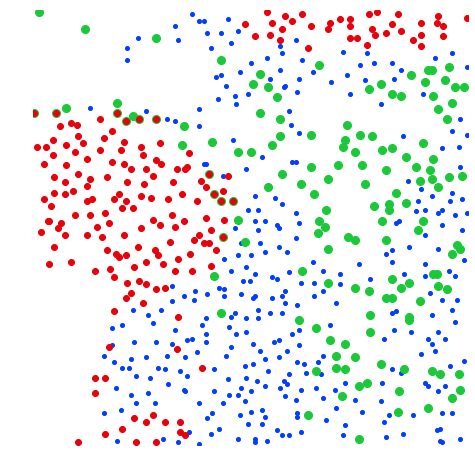

In [32]:
f = plt.figure(figsize=(8, 8))
plt.imshow(np.ones(shape[1:]), cmap='gray', clim=[0, 1])
plt.plot(dn_centers[:, 2], dn_centers[:, 1], marker='.', color=cmap[0], markersize=8, linestyle='none')
plt.plot(tbr1_centers[:, 2], tbr1_centers[:, 1], marker='.', color=cmap[2], markersize=16, linestyle='none')
plt.plot(sox2_centers[:, 2], sox2_centers[:, 1], marker='.', color=cmap[3], markersize=12, linestyle='none')
sns.despine()
plt.axis('off')
plt.show()

In [33]:
mfis = np.load(os.path.join(working_dir, 'single_cell_mfi.npy'))
mfis.shape

(2421822, 2)

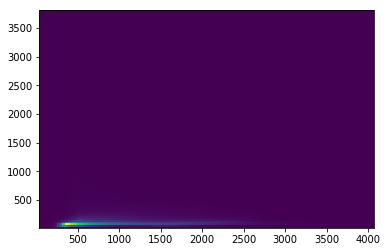

In [34]:
plt.hist2d(mfis[:, 0], mfis[:, 1], bins=128)
plt.show()

In [35]:
# random sample
n = 1000

np.random.seed(123)
idx = np.arange(len(mfis))
np.random.shuffle(idx)
idx = idx[:n]

In [36]:
# subvolume sample
start = np.array([120, 450, 550])
shape = np.array([128, 256, 256])

stop = start + shape

centers_box_global, idx = utils.filter_points_in_box(centers, start, stop, return_idx=True)
sox2_labels[idx].sum(), tbr1_labels[idx].sum()

(5058, 4793)

/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


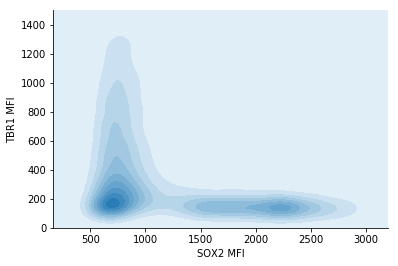

In [37]:
f = plt.figure(figsize=(6, 4))
ax = sns.kdeplot(mfis[idx, 0], mfis[idx, 1], shade=True, shade_lowest=True, vmax=None, clip=[(0, 3200), (0, 1500)])
plt.xlabel('SOX2 MFI')
plt.ylabel('TBR1 MFI')
sns.despine()

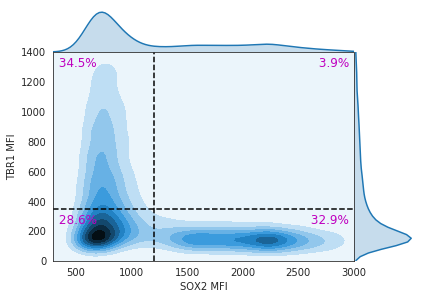

In [38]:
sox2_gate = 1200
tbr1_gate = 350

xlim = (300, 3000)
ylim = (0, 1400)

top_left = (310, 1300)
top_right = (2650, 1300)
btm_left = (310, 250)
btm_right = (2580, 250)
text_size = 12

df = pd.DataFrame({'SOX2 MFI': mfis[idx, 0], 'TBR1 MFI': mfis[idx, 1]})

top_left_count = len(np.where(np.logical_and(df['SOX2 MFI'] < sox2_gate, df['TBR1 MFI'] >= tbr1_gate))[0])
top_right_count = len(np.where(np.logical_and(df['SOX2 MFI'] >= sox2_gate, df['TBR1 MFI'] >= tbr1_gate))[0])
btm_left_count = len(np.where(np.logical_and(df['SOX2 MFI'] < sox2_gate, df['TBR1 MFI'] < tbr1_gate))[0])
btm_right_count = len(np.where(np.logical_and(df['SOX2 MFI'] >= sox2_gate, df['TBR1 MFI'] < tbr1_gate))[0])
total = len(df)

sns.set_style("white")
g = sns.jointplot("SOX2 MFI", "TBR1 MFI", data=df, kind="kde", space=0, xlim=xlim, ylim=ylim, gridsize=200)
g.fig.set_figwidth(6)
g.fig.set_figheight(4)
g.ax_joint.plot([sox2_gate, sox2_gate], ylim, 'k--')
g.ax_joint.plot(xlim, [tbr1_gate, tbr1_gate], 'k--')
g.ax_joint.text(*top_left, f'{top_left_count/total*100 : .1f}%', fontsize=text_size, color='m')
g.ax_joint.text(*top_right, f'{top_right_count/total*100 : .1f}%', fontsize=text_size, color='m')
g.ax_joint.text(*btm_left, f'{btm_left_count/total*100 : .1f}%', fontsize=text_size, color='m')
g.ax_joint.text(*btm_right, f'{btm_right_count/total*100 : .1f}%', fontsize=text_size, color='m')

g.savefig(os.path.join(working_dir, 'sox2_tbr1_kde.pdf'), bbox_inches='tight')

# Figure 2E - Nuclei morpholigies by cell type

In [17]:
seg = tifffile.imread(os.path.join(working_dir, 'pseg_compressed.tif'))
seg.shape, seg.dtype, seg.max()

((650, 2364, 2376), dtype('float32'), 2414061.0)

In [18]:
seg = seg.astype(np.int32)
seg.shape, seg.dtype, seg.max()

((650, 2364, 2376), dtype('int32'), 2414061)

In [19]:
props = measure.regionprops(seg)

In [21]:
centroids = []
volumes = []
eq_diams = []
inertia_eigvals = []
inertia_ratios = []
minor_axis_lengths = []
major_axis_lengths = []

for i, region in tqdm(enumerate(props), total=len(props)):
    inertia_eigval = region.inertia_tensor_eigvals
    inertia_ratio = inertia_eigval[0]/max(1e-6, inertia_eigval[1])
    
    centroids.append(region.centroid)
    volumes.append(region.area)
    eq_diams.append(region.equivalent_diameter)
    inertia_eigvals.append(inertia_eigval)
    inertia_ratios.append(inertia_ratio)
    minor_axis_lengths.append(region.minor_axis_length)
    major_axis_lengths.append(region.major_axis_length)

In [22]:
centroids_arr = np.asarray(centroids)
volumes_arr = np.asarray(volumes)
eq_diams_arr = np.asarray(eq_diams)
eigvals_arr = np.asarray(inertia_eigvals)
ratios_arr = np.asarray(inertia_ratios)
minor_axis_lengths_arr = np.asarray(minor_axis_lengths)
major_axis_lengths_arr = np.asarray(major_axis_lengths)

In [23]:
np.save(os.path.join(working_dir, 'morphology_centroids.npy'), centroids_arr)
np.save(os.path.join(working_dir, 'morphology_volumes.npy'), volumes_arr)
np.save(os.path.join(working_dir, 'morphology_eq_diams.npy'), eq_diams_arr)
np.save(os.path.join(working_dir, 'morphology_inertia_eigvals.npy'), eigvals_arr)
np.save(os.path.join(working_dir, 'morphology_inertia_ratio.npy'), ratios_arr)
np.save(os.path.join(working_dir, 'morphology_minor_axis.npy'), minor_axis_lengths_arr)
np.save(os.path.join(working_dir, 'morphology_major_axis.npy'), major_axis_lengths_arr)

In [ ]:
centroids_arr = np.load(os.path.join(working_dir, 'morphology_centroids.npy'))
volumes_arr = np.load(os.path.join(working_dir, 'morphology_volumes.npy'))
eq_diams_arr = np.load(os.path.join(working_dir, 'morphology_eq_diams.npy'))
eigvals_arr = np.load(os.path.join(working_dir, 'morphology_inertia_eigvals.npy'))
ratios_arr = np.load(os.path.join(working_dir, 'morphology_inertia_ratio.npy'))
minor_axis_lengths_arr = np.load(os.path.join(working_dir, 'morphology_minor_axis.npy'))
major_axis_lengths_arr = np.load(os.path.join(working_dir, 'morphology_major_axis.npy'))

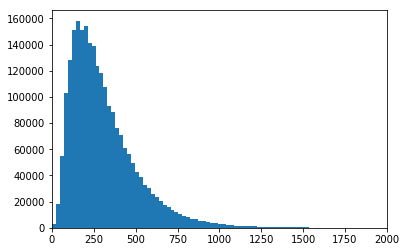

In [24]:
plt.hist(volumes, bins=512)
plt.xlim([0, 2000])
plt.show()

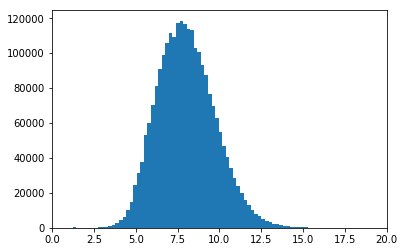

In [25]:
plt.hist(eq_diams_arr, bins=128)
plt.xlim([0, 20])
plt.show()

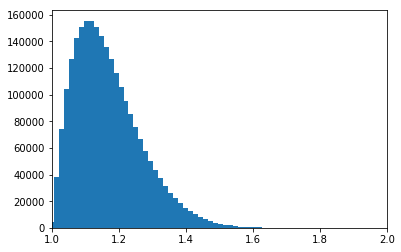

In [26]:
plt.hist(ratios_arr, bins=128)
plt.xlim([1, 2])
plt.show()

In [27]:
# match segmentation centroid with nearest nuclei center
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=1).fit(centers)

In [28]:
centroids_arr.shape

(2414061, 3)

In [29]:
distances, indices = nbrs.kneighbors(centroids_arr)
distances.shape

(2414061, 1)

In [30]:
centroids_idx = indices[:, 0]

In [75]:
# subvolume sample
start = np.array([120, 450, 550])
shape = np.array([128, 256, 256])

stop = start + shape
centers_box_global, box_idx = utils.filter_points_in_box(centers, start, stop, return_idx=True)

In [77]:
centroids_idx_box = []
for i in tqdm(centroids_idx, total=len(centroids_idx)):
    # i is index into centers
    if i in box_idx:
        centroids_idx_box.append(i)
centroids_idx_box = np.asarray(centroids_idx_box)
centroids_idx_box.shape

(16443,)

In [31]:
sox2_idx = np.where(sox2_labels[centroids_idx] == 1)[0]
tbr1_idx = np.where(tbr1_labels[centroids_idx] == 1)[0]
dn_idx = np.where(~np.logical_or(sox2_labels[centroids_idx] == 1, tbr1_labels[centroids_idx] ==1))[0]

len(sox2_idx), len(tbr1_idx), len(dn_idx)

(620724, 130481, 1687917)

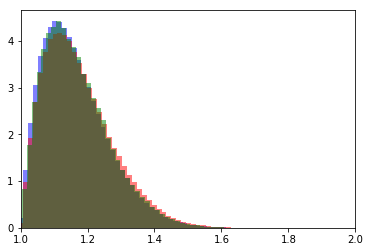

In [93]:
bins = 128
plt.hist(ratios_arr[dn_idx], color='b', bins=bins, density=True, alpha=0.5)
plt.hist(ratios_arr[sox2_idx], color='r', bins=bins, density=True, alpha=0.5)
plt.hist(ratios_arr[tbr1_idx], color='g', bins=bins, density=True, alpha=0.5)
plt.xlim([1, 2])
plt.show()

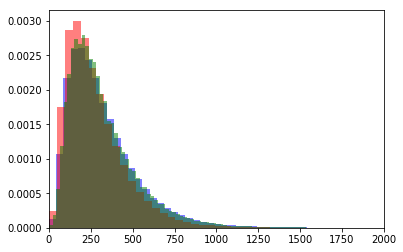

In [92]:
bins = 256
plt.hist(volumes_arr[dn_idx], color='b', bins=bins, density=True, alpha=0.5)
plt.hist(volumes_arr[sox2_idx], color='r', bins=bins, density=True, alpha=0.5)
plt.hist(volumes_arr[tbr1_idx], color='g', bins=bins, density=True, alpha=0.5)
plt.xlim([0, 2000])
plt.show()

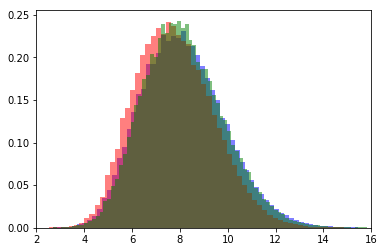

In [91]:
bins = 128
plt.hist(eq_diams_arr[dn_idx], color='b', bins=bins, density=True, alpha=0.5)
plt.hist(eq_diams_arr[sox2_idx], color='r', bins=bins, density=True, alpha=0.5)
plt.hist(eq_diams_arr[tbr1_idx], color='g', bins=bins, density=True, alpha=0.5)
plt.xlim([2, 16])
plt.show()

In [11]:
eq_diams_arr[dn_idx].mean()

NameError: name 'eq_diams_arr' is not defined

In [114]:
from phathom.phenotype import mesh

In [122]:
cell_type = []
for s, t in tqdm(zip(sox2_labels[centroids_idx], tbr1_labels[centroids_idx])):
    if t == 1:
        cell_type.append('TBR1+')
        continue
    if s == 1:
        cell_type.append('SOX2+')
        continue
    cell_type.append('DN')
cell_type = np.asarray(cell_type)

In [202]:
np.random.seed(678)
diam, minor, major, ct, eigvals = mesh.randomly_sample(300000, 
                                                       eq_diams_arr, 
                                                       minor_axis_lengths_arr, 
                                                       major_axis_lengths_arr, 
                                                       cell_type, 
                                                       eigvals_arr)

In [203]:
diam = diam[np.where(ct != 'DN')]
minor = minor[np.where(ct != 'DN')]
major = major[np.where(ct != 'DN')]
eigvals = eigvals[np.where(ct != 'DN')]
ct = ct[np.where(ct != 'DN')]

/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 60)

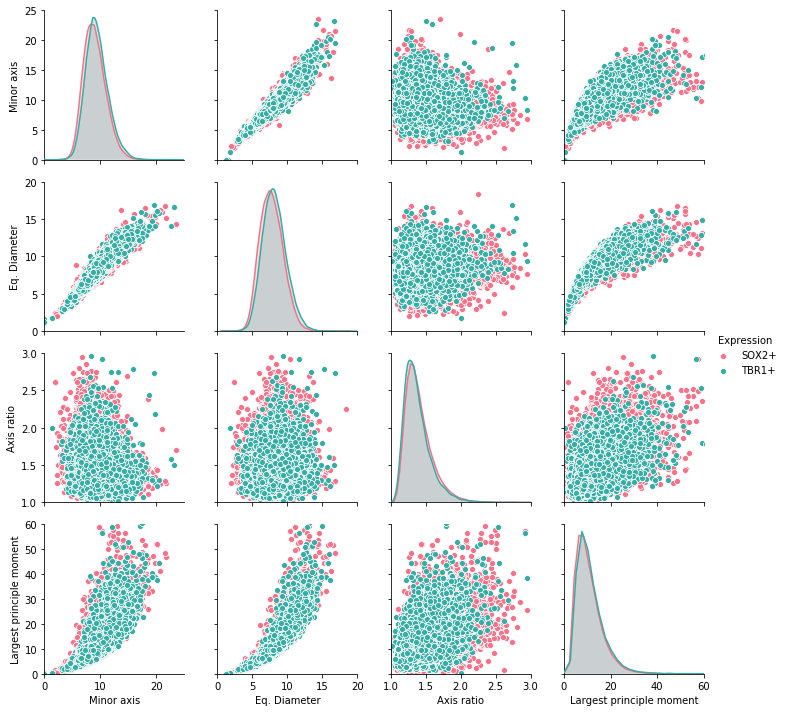

In [207]:
df = pd.DataFrame({'Minor axis': minor, 
                   'Eq. Diameter': diam, 
                   'Axis ratio': major/minor,
                   'Largest principle moment' : eigvals[:, 0],
                   'Expression': ct})

g = sns.pairplot(df, hue='Expression', palette='husl', plot_kws={'alpha': 1.0})

g.axes[0, 0].set_xlim((0, 25))
g.axes[0, 1].set_xlim((0, 20))
g.axes[0, 2].set_xlim((1, 3))
g.axes[0, 3].set_xlim((0, 60))

g.axes[0, 1].set_ylim((0, 25))
g.axes[1, 0].set_ylim((0, 20))
g.axes[2, 0].set_ylim((1, 3))
g.axes[3, 0].set_ylim((0, 60))

In [4]:
from phathom.phenotype import mesh
from tqdm import tqdm_notebook as tqdm

In [73]:
n_samples = 1000
sample_size = 2000

np.random.seed(678)

# sox2_idx = np.where(sox2_labels == 1)[0]
# tbr1_idx = np.where(tbr1_labels == 1)[0]
# dn_idx = np.where(~np.logical_or(sox2_labels == 1, tbr1_labels ==1))[0]

minor_sox2_list = []
major_sox2_list = []
minor_tbr1_list = []
major_tbr1_list = []
minor_dn_list = []
major_dn_list = []

diam_sox2_list = []
diam_tbr1_list = []
diam_dn_list = []


for i in tqdm(range(n_samples)):
    
    minor_sox2, major_sox2 = mesh.randomly_sample(sample_size, 
                                                  minor_axis_lengths_arr[sox2_idx], 
                                                  major_axis_lengths_arr[sox2_idx])
    minor_tbr1, major_tbr1 = mesh.randomly_sample(sample_size, 
                                                  minor_axis_lengths_arr[tbr1_idx], 
                                                  major_axis_lengths_arr[tbr1_idx])
    minor_dn, major_dn = mesh.randomly_sample(sample_size, 
                                                  minor_axis_lengths_arr[dn_idx], 
                                                  major_axis_lengths_arr[dn_idx])
    
    eq_diam_sox2 = mesh.randomly_sample(sample_size, minor_axis_lengths_arr[sox2_idx])[0]
    eq_diam_tbr1 = mesh.randomly_sample(sample_size, minor_axis_lengths_arr[tbr1_idx])[0]
    eq_diam_dn = mesh.randomly_sample(sample_size, minor_axis_lengths_arr[dn_idx])[0]
    
    minor_sox2_mean, major_sox2_mean = minor_sox2.mean(), major_sox2.mean()
    minor_tbr1_mean, major_tbr1_mean = minor_tbr1.mean(), major_tbr1.mean()
    minor_dn_mean, major_dn_mean = minor_dn.mean(), major_dn.mean()
                                                                            
    diam_sox2 = eq_diam_sox2.mean()
    diam_tbr1 = eq_diam_tbr1.mean()
    diam_dn = eq_diam_dn.mean()
    
    minor_sox2_list.append(minor_sox2_mean)
    minor_tbr1_list.append(minor_tbr1_mean)
    minor_dn_list.append(minor_dn_mean)
    
    major_sox2_list.append(major_sox2_mean)
    major_tbr1_list.append(major_tbr1_mean)
    major_dn_list.append(major_dn_mean)
                                                                                
    diam_sox2_list.append(diam_sox2)
    diam_tbr1_list.append(diam_tbr1)
    diam_dn_list.append(diam_dn)

In [74]:
minor_sox2 = np.asarray(minor_sox2_list)
major_sox2 = np.asarray(major_sox2_list)
minor_tbr1 = np.asarray(minor_tbr1_list)
major_tbr1 = np.asarray(major_tbr1_list)
minor_dn = np.asarray(minor_dn_list)
major_dn = np.asarray(major_dn_list)

diam_sox2 = np.asarray(diam_sox2_list)
diam_tbr1 = np.asarray(diam_tbr1_list)
diam_dn = np.asarray(diam_dn_list)

/home/jswaney/anaconda3/envs/phathom/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


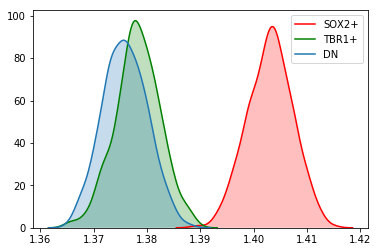

In [75]:
ratio_sox2 = major_sox2 / minor_sox2
ratio_tbr1 = major_tbr1 / minor_tbr1
ratio_dn = major_dn / minor_dn
sns.kdeplot(ratio_sox2, color='r', shade=True, label='SOX2+')
sns.kdeplot(ratio_tbr1, color='g', shade=True, label='TBR1+')
sns.kdeplot(ratio_dn, shade=True, label='DN')

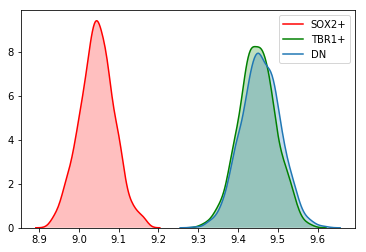

In [76]:
sns.kdeplot(diam_sox2, color='r', shade=True, label='SOX2+')
sns.kdeplot(diam_tbr1, color='g', shade=True, label='TBR1+')
sns.kdeplot(diam_dn, shade=True, label='DN')

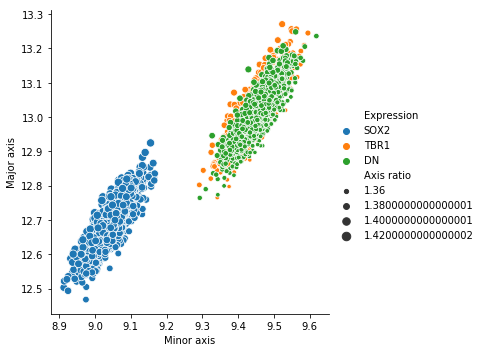

In [69]:
df = pd.DataFrame({'Minor axis': np.concatenate([minor_sox2, minor_tbr1, minor_dn]),
                   'Major axis': np.concatenate([major_sox2, major_tbr1, major_dn]),
                   'Axis ratio': np.concatenate([ratio_sox2, ratio_tbr1, ratio_dn]),
                   'Expression': np.asarray(n_samples*['SOX2'] + n_samples*['TBR1'] + n_samples*['DN'])})

sns.relplot(x='Minor axis', y='Major axis', hue='Expression', data=df, size='Axis ratio')

# sns.kdeplot(x='Minor axis', y='Major axis', hue='Expression', data=df)

# Figure 2E - Double negative niche clustering